In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np




class PatchDataset(Dataset):
    def __init__(self, image_dir, patch_size=100, transform=None):
        self.image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".jpg")]
        self.patch_size = patch_size
        self.transform = transform
        self.patches = []

        # Extrahiere alle Patches beim Init
        for path in self.image_paths:
            img = Image.open(path).convert("RGB")
            w, h = img.size
            for i in range(0, h, patch_size):
                for j in range(0, w, patch_size):
                    if i+patch_size <= h and j+patch_size <= w:
                        patch = img.crop((j, i, j+patch_size, i+patch_size))
                        self.patches.append(patch)

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        img = self.patches[idx]
        if self.transform:
            img = self.transform(img)
        return img

transform = transforms.Compose([
    transforms.ToTensor(),             # [0,1]
    transforms.Lambda(lambda x: x * 2 - 1)  # [-1,1]
])




dataset = PatchDataset("data/aerialimagelabeling/train/104_sat.jpg", transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


In [16]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST

# Transformationen: Tensor + [-1, 1] Normalisierung
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2 - 1)
])

# MNIST Dataset laden (Training)
dataset = MNIST(root="data", train=True, download=True, transform=transform)

# DataLoader
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Testweise ein Batch anzeigen
for batch in dataloader:
    imgs, labels = batch  # imgs: [64, 1, 28, 28], labels: [64]
    print(imgs.shape, labels.shape)
    break

torch.Size([64, 1, 28, 28]) torch.Size([64])


In [17]:
def linear_beta_schedule(timesteps):
    beta_start = 1e-4
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

timesteps = 1000
betas = linear_beta_schedule(timesteps)

alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)

def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)
    sqrt_alpha = sqrt_alphas_cumprod[t][:, None, None, None]
    sqrt_one_minus_alpha = sqrt_one_minus_alphas_cumprod[t][:, None, None, None]
    return sqrt_alpha * x_start + sqrt_one_minus_alpha * noise


In [18]:
import torch.nn as nn
import math

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = t[:, None] * emb[None, :]
        return torch.cat([emb.sin(), emb.cos()], dim=-1)

def conv_block(in_c, out_c):
    return nn.Sequential(
        nn.Conv2d(in_c, out_c, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_c, out_c, 3, padding=1),
        nn.ReLU()
    )

class UNet(nn.Module):
    def __init__(self, in_channels=1, base_channels=64, time_emb_dim=256):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )

        self.conv1 = conv_block(in_channels, base_channels)
        self.conv2 = conv_block(base_channels, base_channels * 2)
        self.pool = nn.MaxPool2d(2)
        self.up = nn.ConvTranspose2d(base_channels * 2, base_channels, 2, stride=2)
        self.out_conv = nn.Conv2d(base_channels, in_channels, 1)

        self.time_linear1 = nn.Linear(time_emb_dim, base_channels)
        self.time_linear2 = nn.Linear(time_emb_dim, base_channels * 2)

    def forward(self, x, t):
        t_emb = self.time_mlp(t)  # [B, time_emb_dim]
        t1 = self.time_linear1(t_emb).unsqueeze(-1).unsqueeze(-1)  # [B, C1, 1, 1]
        t2 = self.time_linear2(t_emb).unsqueeze(-1).unsqueeze(-1)  # [B, C2, 1, 1]

        x1 = self.conv1(x) + t1  # [B, C1, H, W]
        x2 = self.conv2(self.pool(x1)) + t2  # [B, C2, H/2, W/2]
        x3 = self.up(x2)  # [B, C1, H, W]
        x_out = self.out_conv(x3 + x1)  # Skip Connection
        return x_out


In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

epochs = 3

for epoch in range(epochs):
    for x, _ in dataloader:
        x = x.to(device)
        t = torch.randint(0, timesteps, (x.size(0),), device=device).long()
        noise = torch.randn_like(x)
        x_noisy = q_sample(x, t, noise)
        predicted_noise = model(x_noisy, t.float())

        loss = loss_fn(predicted_noise, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}: loss = {loss.item():.4f}")


Epoch 1: loss = 0.0604
Epoch 2: loss = 0.0715
Epoch 3: loss = 0.0491


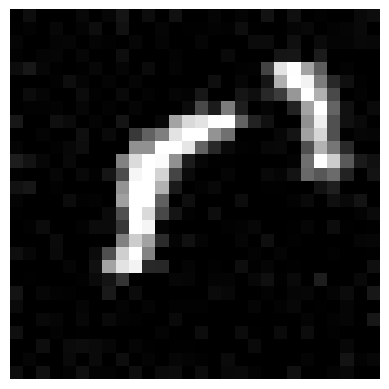

In [26]:
import matplotlib.pyplot as plt

@torch.no_grad()
def sample(model, img_size=28, n=1):
    model.eval()
    x = torch.randn((n, 1, img_size, img_size)).to(device)

    for t in reversed(range(timesteps)):
        t_batch = torch.full((n,), t, device=device, dtype=torch.float)
        pred_noise = model(x, t_batch)
        alpha = alphas[t]
        alpha_hat = alphas_cumprod[t]
        beta = betas[t]

        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = 0

        x = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / torch.sqrt(1 - alpha_hat)) * pred_noise) + torch.sqrt(beta) * noise

    return x

# Samplen und anzeigen
samples = sample(model)
samples = (samples.clamp(-1, 1) + 1) / 2  # zurück auf [0,1]

for i in range(samples.size(0)):
    img = samples[i].permute(1, 2, 0).cpu().numpy()
    plt.imshow(img, cmap="gray")  # ← erzwingt Graustufenanzeige
    plt.axis("off")
    plt.show()
  
